In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import numpy as np
from scipy.ndimage import distance_transform_edt as edt
import matplotlib.pyplot as plt


In [2]:
class MNISTSDF(Dataset):
    def __init__(self, split='train', size=64, sample_points=None, data_root='./data'):
        self.size = size
        self.sample_points = sample_points
        self.ds = datasets.MNIST(data_root, train=(split=='train'), download=True)
        self.to_tensor = transforms.Compose([
            transforms.Resize((size, size), antialias=True),
            transforms.ToTensor()
        ])
        # compat meshgrid
        ys, xs = torch.linspace(-1,1,size), torch.linspace(-1,1,size)
        yy, xx = torch.meshgrid(ys, xs)  # works everywhere
        self.coords_full = torch.stack([xx, yy], dim=-1).reshape(-1, 2)

    def __len__(self): return len(self.ds)

    def __getitem__(self, idx):
        img_pil, _ = self.ds[idx]
        img = self.to_tensor(img_pil)[0].numpy()
        mask = (img >= 0.5).astype(np.uint8)

        # signed distance (negative inside), normalized by diagonal
        dist_out = edt(1 - mask).astype(np.float32)
        dist_in  = edt(mask).astype(np.float32)
        sdf = (dist_out - dist_in) / np.sqrt(self.size**2 + self.size**2)

        coords = self.coords_full
        sdf_flat = torch.from_numpy(sdf).view(-1,1)

        if self.sample_points is not None and self.sample_points < coords.shape[0]:
            ids = torch.randperm(coords.shape[0])[:self.sample_points]
            coords, sdf_flat = coords[ids], sdf_flat[ids]

        return {
            "idx": idx,
            "coords": coords.float(),           # [N,2]
            "sdf": sdf_flat.float(),            # [N,1]
            "sdf_full": torch.from_numpy(sdf)[None].float()  # [1,H,W]
            # "label": label,  # optional
        }


/home/azhir/miniconda3/envs/metaPDE/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1739474892959/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


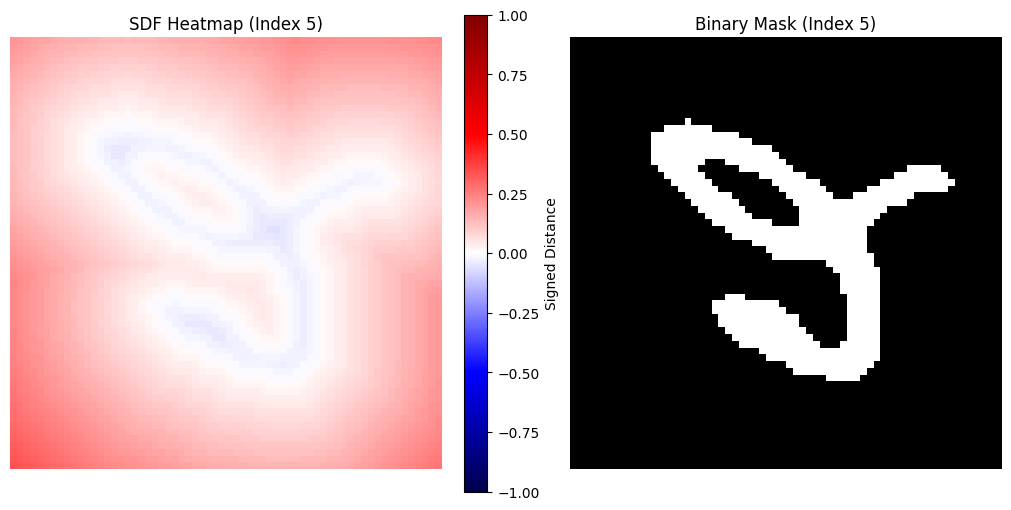

In [3]:
# create dataset
ds = MNISTSDF(split='train', size=64, sample_points=None)

# pick an index to view
idx_to_view = 5
sample = ds[idx_to_view]

# unpack
coords = sample["coords"]
sdf_full = sample["sdf_full"].numpy()[0]  # [H,W]
digit_label = idx_to_view  # optional

# plot SDF heatmap and Binary Mask with the same height
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Plot SDF heatmap
im0 = axes[0].imshow(sdf_full, cmap='seismic', origin='lower', vmin=-1, vmax=1)
axes[0].set_title(f"SDF Heatmap (Index {idx_to_view})")
axes[0].axis('off')
fig.colorbar(im0, ax=axes[0], label='Signed Distance')

# Plot Binary Mask
binary_mask = (sdf_full < 0).astype(float)
im1 = axes[1].imshow(binary_mask, cmap='gray', origin='lower')
axes[1].set_title(f"Binary Mask (Index {idx_to_view})")
axes[1].axis('off')

plt.show()


In [4]:
# dataset for full grids (good for viz) or subsampled (fast DeepSDF)
ds_full  = MNISTSDF(split='train', size=64, sample_points=None)
ds_sub   = MNISTSDF(split='train', size=64, sample_points=4096)

# Model DeepSDF

In [5]:
# class DeepSDF(nn.Module):
#     def __init__(self, z_dim=64, width=128, depth=4):
#         super().__init__()
#         self.z_dim = z_dim
#         layers=[]; last=2+z_dim
#         for _ in range(depth):
#             layers += [nn.Linear(last, width), nn.ReLU(inplace=True)]
#             last = width
#         layers += [nn.Linear(last, 1)]
#         self.net = nn.Sequential(*layers)
#     def forward(self, coords, z):
#         if z.dim()==1: z = z[None,:]
#         N = coords.shape[0]
#         zrep = z[:,None,:].expand(1,N,z.shape[-1]).reshape(N,-1)
#         return self.net(torch.cat([coords, zrep], -1))

class DeepSDF(nn.Module):
    def __init__(self, z_dim=64, width=128, depth=4):
        super().__init__()
        layers = []; last = 2 + z_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU(inplace=True)]
            last = width
        layers += [nn.Linear(last, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, coords, z):
        # coords: (B,N,2) or (N,2); z: (B,D) or (D,)
        if coords.dim() == 2:
            coords = coords[None, ...]
        if z.dim() == 1:
            z = z[None, ...]
        B, N, _ = coords.shape
        zrep = z[:, None, :].expand(B, N, z.shape[-1])
        x = torch.cat([coords, zrep], dim=-1).reshape(B * N, -1)
        out = self.net(x).reshape(B, N, 1)
        return out



def sdf_loss(pred, gt, band=0.2):
    p = pred.squeeze(-1); g = gt.squeeze(-1)
    near = (g.abs() < band).float()
    l_sdf = (near * (p - g).abs()).mean()
    occ = torch.sigmoid(-p)                 # negative => inside
    l_occ = F.binary_cross_entropy(occ, (g < 0).float())
    return l_sdf + 0.5*l_occ

def clamped_l1(pred, gt, δ=0.1):
    return torch.clamp((pred-gt).abs(), max=δ).mean()



In [6]:
# --- data ---
def collate(batch):
    coords = torch.stack([b["coords"]   for b in batch], 0)  # (B,N,2)
    sdf    = torch.stack([b["sdf"]      for b in batch], 0)  # (B,N,1)
    idx    = torch.tensor([b["idx"]     for b in batch], dtype=torch.long)
    return coords, sdf, idx

train_ds = MNISTSDF(split='train', size=64, sample_points=4096)
# create dataset
train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=True,
    collate_fn=collate
)



# Use your MNISTSDF class; subsample for speed if needed
# train_ds = MNISTSDF(split='train', size=64, sample_points=4096)
# train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True, collate_fn=lambda x: x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# --- data ---
def collate(batch):
    coords = torch.stack([b["coords"]   for b in batch], 0)  # (B,N,2)
    sdf    = torch.stack([b["sdf"]      for b in batch], 0)  # (B,N,1)
    idx    = torch.tensor([b["idx"]     for b in batch], dtype=torch.long)
    return coords, sdf, idx

train_ds = MNISTSDF(split='train', size=64, sample_points=4096)
# create dataset
train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=True,
    collate_fn=collate
)



model = DeepSDF(z_dim=64, width=128, depth=4).to(device)

latents = nn.Embedding(len(train_ds), 64, sparse=True).to(device)
nn.init.normal_(latents.weight, mean=0.0, std=0.01)

opt_theta = torch.optim.Adam(model.parameters(), lr=5e-4)
opt_z     = torch.optim.SparseAdam(latents.parameters(), lr=1e-3)

scaler = torch.cuda.amp.GradScaler()
λ = 1e-3  # a bit stronger prior is helpful on MNIST

for ep in range(1, 6):
    model.train(); losses=[]
    for coords, sdf, idx in train_loader:
        coords = coords.to(device, non_blocking=True)
        sdf    = sdf.to(device, non_blocking=True)
        idx    = idx.to(device, non_blocking=True)

        z = latents(idx)  # (B,64)

        opt_theta.zero_grad(set_to_none=True)
        opt_z.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            pred = model(coords, z)          # (B,N,1)
            loss = sdf_loss(pred, sdf) + λ * z.pow(2).mean()

        scaler.scale(loss).backward()
        scaler.step(opt_theta); scaler.step(opt_z)
        scaler.update()

        losses.append(loss.item())
    print(f"epoch {ep} | train {np.mean(losses):.4e}")


/tmp/ipykernel_1547908/2120221253.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/azhir/miniconda3/envs/metaPDE/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


/tmp/ipykernel_1547908/2120221253.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/azhir/miniconda3/envs/metaPDE/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

# ---------- loss ----------
@torch.cuda.amp.autocast(enabled=False)
def sdf_occ_loss(pred_sdf, gt_sdf, band=0.2):
    # pred_sdf, gt_sdf: (B,N,1)
    p = pred_sdf.squeeze(-1)
    g = gt_sdf.squeeze(-1)

    # near-surface L1
    near = (g.abs() < band).float()
    l_sdf = (near * (p - g).abs()).sum() / (near.sum().clamp_min(1.0))

    # occupancy/sign (inside if sdf<0)
    occ_pred = torch.sigmoid(-p)
    occ_tgt  = (g < 0).float()
    l_occ = F.binary_cross_entropy(occ_pred, occ_tgt)

    return l_sdf + 0.5 * l_occ

# ---------- fast trainer ----------
def train_deepsdf_fast(
    train_ds, model, device="cuda",
    z_dim=64, batch_size=32, points_per_step=4096,
    lr_theta=5e-4, lr_z=1e-3, weight_decay=1e-4,
    lambda_z=1e-3, epochs=5, num_workers=4, amp=True, compile_model=True
):
    loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers>0),
        collate_fn=lambda batch: (
            torch.stack([b["coords"] for b in batch], 0),  # (B,N,2)
            torch.stack([b["sdf"]    for b in batch], 0),  # (B,N,1)
            torch.tensor([b["idx"]   for b in batch], dtype=torch.long),
        )
    )

    # per-sample latents (sparse updates)
    latents = nn.Embedding(len(train_ds), z_dim, sparse=True).to(device)
    nn.init.normal_(latents.weight, mean=0.0, std=0.01)

    model = model.to(device)
    if compile_model and hasattr(torch, "compile"):
        model = torch.compile(model)

    opt_theta = torch.optim.AdamW(model.parameters(), lr=lr_theta, weight_decay=weight_decay)
    opt_z     = torch.optim.SparseAdam(latents.parameters(), lr=lr_z)

    # cosine LR (optional but nice)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt_theta, T_max=epochs, eta_min=lr_theta*0.1)

    scaler = torch.cuda.amp.GradScaler(enabled=amp)

    model.train()
    for ep in range(1, epochs+1):
        losses = []
        for coords, sdf, idx in loader:
            coords = coords.to(device, non_blocking=True)  # (B,N,2)
            sdf    = sdf.to(device, non_blocking=True)     # (B,N,1)
            idx    = idx.to(device, non_blocking=True)     # (B,)

            # subsample points per step for speed
            B, N, _ = coords.shape
            if N > points_per_step:
                sel = torch.randint(0, N, (points_per_step,), device=device)
                coords = coords[:, sel]
                sdf    = sdf[:, sel]

            z = latents(idx)  # (B, z_dim)

            opt_theta.zero_grad(set_to_none=True)
            opt_z.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=amp):
                pred = model(coords, z)                       # (B, npts, 1)
                loss = sdf_occ_loss(pred, sdf) + lambda_z * z.pow(2).mean()

            scaler.scale(loss).backward()
            scaler.step(opt_theta)
            scaler.step(opt_z)
            scaler.update()

            losses.append(loss.item())

        sched.step()
        print(f"epoch {ep} | train {np.mean(losses):.4e} | lr {sched.get_last_lr()[0]:.2e}")

    return model, latents


In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = DeepSDF(z_dim=64, width=128, depth=4).to(device)

# latents = nn.Embedding(len(train_ds), 64, sparse=True).to(device)
# nn.init.normal_(latents.weight, mean=0.0, std=0.01)

# opt_theta = torch.optim.Adam(model.parameters(), lr=3e-4)
# opt_z     = torch.optim.SparseAdam(latents.parameters(), lr=1e-3)

In [ ]:
# # --- train ---
# EPOCHS=5
# for ep in range(1, EPOCHS+1):
#     model.train(); latents.train(); losses=[]
#     for batch in train_loader:
#         opt_theta.zero_grad(); opt_z.zero_grad()
#         total = 0.0
#         for b in batch:
#             idx = b["idx"]
#             x   = b["coords"].to(device)
#             y   = b["sdf"].to(device)
#             z   = latents(torch.tensor(idx, device=device))
#             pred = model(x, z)
#             loss = sdf_loss(pred, y) + 1e-4 * z.pow(2).mean()  # small latent L2
#             total = total + loss
#         (total/len(batch)).backward()
#         opt_theta.step(); opt_z.step()
#         losses.append(total.item()/len(batch))
#     print(f"epoch {ep}/{EPOCHS} | train {np.mean(losses[-100:]):.4e}")


KeyboardInterrupt: 